In [6]:
import argparse
import os
import sys
import keras
import numpy as np
import pickle
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
import itertools
import matplotlib.pyplot as plt
from Levenshtein import distance
from sklearn.metrics import confusion_matrix
from prondict import prondict
from keras.models import load_model

### Standardisation

In [8]:
import numpy as np
import argparse
from sklearn import preprocessing
# from sklearn.externals import joblib


# Default values for CLI arguments
DEFAULT_TRAIN_PATH = "Lab3_files/lmfcc_d_training_data.npy"
DEFAULT_VAL_PATH =  "Lab3_files/lmfcc_d_validation_data.npy"
DEFAULT_TEST_PATH =  "Lab3_files/lmfcc_d_test_data.npy"
DEFAULT_STATE_LIST_PATH = "Lab3_files/state_list.npy"
DEFAULT_PREPROCESSOR_SAVE_PATH = "Lab3_files/scaler.save"


state_list = list(np.load(DEFAULT_STATE_LIST_PATH))

# Load training dataset
training_data = np.load(DEFAULT_TRAIN_PATH, allow_pickle=True)
N = 0
D = np.prod(np.array(training_data[0]['features']).shape[1:3])
for sample in training_data:
    N += sample['features'].shape[0]


X_train = np.zeros((N, D))
y_train = np.zeros((N, 1))
prev_idx = 0
for sample in training_data:
    dynamic_features = np.array(sample['features'])
    n = dynamic_features.shape[0]
    X_train[prev_idx:prev_idx + n] = dynamic_features.reshape((n, D))
    y_train[prev_idx:prev_idx + n, 0] = sample['targets']
    prev_idx += n

# Load validation dataset
validation_data = np.load(DEFAULT_VAL_PATH, allow_pickle=True)
N = 0
for sample in validation_data:
    N += np.array(sample['features']).shape[0]

X_val = np.zeros((N, D))
y_val = np.zeros((N, 1))
prev_idx = 0
for sample in validation_data:
    dynamic_features = np.array(sample['features'])
    n = dynamic_features.shape[0]
    X_val[prev_idx:prev_idx + n] = dynamic_features.reshape((n, D))
    y_val[prev_idx:prev_idx + n, 0] = sample['targets']
    prev_idx += n

# Load test dataset
test_data = np.load(DEFAULT_TEST_PATH, allow_pickle=True)
N = 0
for sample in test_data:
    N += np.array(sample['features']).shape[0]

X_test = np.zeros((N, D))
y_test = np.zeros((N, 1))
prev_idx = 0
for sample in test_data:
    dynamic_features = np.array(sample['features'])
    n = dynamic_features.shape[0]
    X_test[prev_idx:prev_idx + n] = dynamic_features.reshape((n, D))
    y_test[prev_idx:prev_idx + n, 0] = sample['targets']
    prev_idx += n

# Standarize
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

np.save("final_data/X_train.npy", X_train)
np.save("final_data/X_val.npy", X_val)
np.save("final_data/X_test.npy", X_test)

np.save("final_data/y_train.npy", y_train)
np.save("final_data/y_val.npy", y_val)
np.save("final_data/y_test.npy", y_test)

(1349413, 91)
(157644, 91)
(1526682, 91)


### model training

In [7]:
# lmfcc_ndy
DEFAULT_HIDDEN_LAYER_NO = 4
DEFAULT_X_TRAIN_PATH = "final_data/lmfcc_ndy/X_train.npy"
DEFAULT_Y_TRAIN_PATH =  "final_data/lmfcc_ndy/y_train.npy"
DEFAULT_X_VAL_PATH =  "final_data/lmfcc_ndy/X_val.npy"
DEFAULT_Y_VAL_PATH =  "final_data/lmfcc_ndy/y_val.npy"
DEFAULT_SAVE_OPTION = True

X_train = np.load(DEFAULT_X_TRAIN_PATH).astype('float32')
y_train = np.load(DEFAULT_Y_TRAIN_PATH)

X_val = np.load(DEFAULT_X_VAL_PATH).astype('float32')
y_val = np.load(DEFAULT_Y_VAL_PATH)

# Convert target arrays to Keras categorical format
stateList = np.load("Lab3_files/state_list.npy")
output_dim = len(stateList)
y_train = np_utils.to_categorical(y_train, output_dim)
y_val = np_utils.to_categorical(y_val, output_dim)




input_dim = X_train.shape[1]

# Define the deep neural network
model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation='relu'))
for i in range(DEFAULT_HIDDEN_LAYER_NO - 1):
    model.add(Dense(256, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=256, \
            validation_data = (X_val, y_val), verbose = 1)

with open("Lab3_files/trainHistoryDict_" + str(DEFAULT_HIDDEN_LAYER_NO), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

if DEFAULT_SAVE_OPTION is True:
    model.save('final_data/model_lmfcc_ndy.h5')
    print("Learned weights are saved")


Train on 1349413 samples, validate on 157644 samples
Epoch 1/25
1349413/1349413 [==============================] - 20s 15us/step - loss: 1.2400 - accuracy: 0.6145 - val_loss: 1.1983 - val_accuracy: 0.6284
Epoch 2/25
1349413/1349413 [==============================] - 20s 15us/step - loss: 1.1193 - accuracy: 0.6464 - val_loss: 1.1996 - val_accuracy: 0.6281
Epoch 3/25
1349413/1349413 [==============================] - 20s 15us/step - loss: 1.0810 - accuracy: 0.6576 - val_loss: 1.1978 - val_accuracy: 0.6305
Epoch 4/25
1349413/1349413 [==============================] - 20s 15us/step - loss: 1.0564 - accuracy: 0.6649 - val_loss: 1.2224 - val_accuracy: 0.6220
Epoch 5/25
1349413/1349413 [==============================] - 20s 15us/step - loss: 1.0382 - accuracy: 0.6705 - val_loss: 1.2131 - val_accuracy: 0.6277
Epoch 6/25
1349413/1349413 [==============================] - 20s 15us/step - loss: 1.0238 - accuracy: 0.6748 - val_loss: 1.2178 - val_accuracy: 0.6273
Epoch 7/25
1349413/1349413 [======

In [9]:
# lmfcc_dy
DEFAULT_HIDDEN_LAYER_NO = 4
DEFAULT_X_TRAIN_PATH = "final_data/lmfcc_dy/X_train.npy"
DEFAULT_Y_TRAIN_PATH =  "final_data/lmfcc_dy/y_train.npy"
DEFAULT_X_VAL_PATH =  "final_data/lmfcc_dy/X_val.npy"
DEFAULT_Y_VAL_PATH =  "final_data/lmfcc_dy/y_val.npy"
DEFAULT_SAVE_OPTION = True

X_train = np.load(DEFAULT_X_TRAIN_PATH).astype('float32')
y_train = np.load(DEFAULT_Y_TRAIN_PATH)

X_val = np.load(DEFAULT_X_VAL_PATH).astype('float32')
y_val = np.load(DEFAULT_Y_VAL_PATH)

# Convert target arrays to Keras categorical format
stateList = np.load("Lab3_files/state_list.npy")
output_dim = len(stateList)
y_train = np_utils.to_categorical(y_train, output_dim)
y_val = np_utils.to_categorical(y_val, output_dim)




input_dim = X_train.shape[1]

# Define the deep neural network
model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation='relu'))
for i in range(DEFAULT_HIDDEN_LAYER_NO - 1):
    model.add(Dense(256, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=256, \
            validation_data = (X_val, y_val), verbose = 1)

with open("Lab3_files/trainHistoryDict_" + str(DEFAULT_HIDDEN_LAYER_NO), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

if DEFAULT_SAVE_OPTION is True:
    model.save('final_data/model_lmfcc_dy.h5')
    print("Learned weights are saved")

Train on 1349413 samples, validate on 157644 samples
Epoch 1/25
1349413/1349413 [==============================] - 28s 21us/step - loss: 0.7632 - accuracy: 0.7493 - val_loss: 0.7147 - val_accuracy: 0.7649
Epoch 2/25
1349413/1349413 [==============================] - 27s 20us/step - loss: 0.6028 - accuracy: 0.7954 - val_loss: 0.6964 - val_accuracy: 0.7723
Epoch 3/25
1349413/1349413 [==============================] - 27s 20us/step - loss: 0.5545 - accuracy: 0.8097 - val_loss: 0.7015 - val_accuracy: 0.7736
Epoch 4/25
1349413/1349413 [==============================] - 27s 20us/step - loss: 0.5267 - accuracy: 0.8179 - val_loss: 0.6864 - val_accuracy: 0.7798
Epoch 5/25
1349413/1349413 [==============================] - 28s 20us/step - loss: 0.5071 - accuracy: 0.8241 - val_loss: 0.6855 - val_accuracy: 0.7835
Epoch 6/25
1349413/1349413 [==============================] - 27s 20us/step - loss: 0.4920 - accuracy: 0.8294 - val_loss: 0.6896 - val_accuracy: 0.7850
Epoch 7/25
1349413/1349413 [=======

In [12]:
# mspec_ndy
DEFAULT_HIDDEN_LAYER_NO = 4
DEFAULT_X_TRAIN_PATH = "final_data/mspec_ndy/X_train.npy"
DEFAULT_Y_TRAIN_PATH =  "final_data/mspec_ndy/y_train.npy"
DEFAULT_X_VAL_PATH =  "final_data/mspec_ndy/X_val.npy"
DEFAULT_Y_VAL_PATH =  "final_data/mspec_ndy/y_val.npy"
DEFAULT_SAVE_OPTION = True

X_train = np.load(DEFAULT_X_TRAIN_PATH).astype('float32')
y_train = np.load(DEFAULT_Y_TRAIN_PATH)

X_val = np.load(DEFAULT_X_VAL_PATH).astype('float32')
y_val = np.load(DEFAULT_Y_VAL_PATH)

# Convert target arrays to Keras categorical format
stateList = np.load("Lab3_files/state_list.npy")
output_dim = len(stateList)
y_train = np_utils.to_categorical(y_train, output_dim)
y_val = np_utils.to_categorical(y_val, output_dim)




input_dim = X_train.shape[1]

# Define the deep neural network
model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation='relu'))
for i in range(DEFAULT_HIDDEN_LAYER_NO - 1):
    model.add(Dense(256, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=256, \
            validation_data = (X_val, y_val), verbose = 1)

with open("Lab3_files/trainHistoryDict_" + str(DEFAULT_HIDDEN_LAYER_NO), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

if DEFAULT_SAVE_OPTION is True:
    model.save('final_data/model_mspec_ndy.h5')
    print("Learned weights are saved")

Train on 1349413 samples, validate on 157644 samples
Epoch 1/25
1349413/1349413 [==============================] - 26s 19us/step - loss: 1.2486 - accuracy: 0.6110 - val_loss: 1.1884 - val_accuracy: 0.6300
Epoch 2/25
1349413/1349413 [==============================] - 25s 19us/step - loss: 1.0915 - accuracy: 0.6553 - val_loss: 1.1681 - val_accuracy: 0.6399
Epoch 3/25
1349413/1349413 [==============================] - 25s 19us/step - loss: 1.0391 - accuracy: 0.6703 - val_loss: 1.1652 - val_accuracy: 0.6420
Epoch 4/25
1349413/1349413 [==============================] - 25s 19us/step - loss: 1.0061 - accuracy: 0.6804 - val_loss: 1.1574 - val_accuracy: 0.6449
Epoch 5/25
1349413/1349413 [==============================] - 25s 19us/step - loss: 0.9828 - accuracy: 0.6875 - val_loss: 1.1642 - val_accuracy: 0.6462
Epoch 6/25
1349413/1349413 [==============================] - 25s 19us/step - loss: 0.9646 - accuracy: 0.6931 - val_loss: 1.1693 - val_accuracy: 0.6432
Epoch 7/25
1349413/1349413 [=======

In [13]:
# mspec_dy
DEFAULT_HIDDEN_LAYER_NO = 4
DEFAULT_X_TRAIN_PATH = "final_data/mspec_dy/X_train.npy"
DEFAULT_Y_TRAIN_PATH =  "final_data/mspec_dy/y_train.npy"
DEFAULT_X_VAL_PATH =  "final_data/mspec_dy/X_val.npy"
DEFAULT_Y_VAL_PATH =  "final_data/mspec_dy/y_val.npy"
DEFAULT_SAVE_OPTION = True

X_train = np.load(DEFAULT_X_TRAIN_PATH).astype('float32')
y_train = np.load(DEFAULT_Y_TRAIN_PATH)

X_val = np.load(DEFAULT_X_VAL_PATH).astype('float32')
y_val = np.load(DEFAULT_Y_VAL_PATH)

# Convert target arrays to Keras categorical format
stateList = np.load("Lab3_files/state_list.npy")
output_dim = len(stateList)
y_train = np_utils.to_categorical(y_train, output_dim)
y_val = np_utils.to_categorical(y_val, output_dim)




input_dim = X_train.shape[1]

# Define the deep neural network
model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation='relu'))
for i in range(DEFAULT_HIDDEN_LAYER_NO - 1):
    model.add(Dense(256, activation='relu'))
model.add(Dense(output_dim, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=256, \
            validation_data = (X_val, y_val), verbose = 1)

with open("Lab3_files/trainHistoryDict_" + str(DEFAULT_HIDDEN_LAYER_NO), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

if DEFAULT_SAVE_OPTION is True:
    model.save('final_data/model_mspec_dy.h5')
    print("Learned weights are saved")

Train on 1349413 samples, validate on 157644 samples
Epoch 1/25
1349413/1349413 [==============================] - 32s 23us/step - loss: 0.8057 - accuracy: 0.7348 - val_loss: 0.7571 - val_accuracy: 0.7524
Epoch 2/25
1349413/1349413 [==============================] - 31s 23us/step - loss: 0.6370 - accuracy: 0.7849 - val_loss: 0.7194 - val_accuracy: 0.7644
Epoch 3/25
1349413/1349413 [==============================] - 30s 23us/step - loss: 0.5911 - accuracy: 0.7989 - val_loss: 0.7258 - val_accuracy: 0.7688
Epoch 4/25
1349413/1349413 [==============================] - 30s 22us/step - loss: 0.5635 - accuracy: 0.8073 - val_loss: 0.7279 - val_accuracy: 0.7682
Epoch 5/25
1349413/1349413 [==============================] - 30s 22us/step - loss: 0.5425 - accuracy: 0.8143 - val_loss: 0.7174 - val_accuracy: 0.7739
Epoch 6/25
1349413/1349413 [==============================] - 30s 22us/step - loss: 0.5273 - accuracy: 0.8189 - val_loss: 0.7379 - val_accuracy: 0.7691
Epoch 7/25
1349413/1349413 [=======

### evaluation

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

Model accuracy - frame by frame - state level: 0.5917787725276121
Normalized confusion matrix
[[3.93704549e-01 3.75816126e-02 6.52900897e-03 ... 5.30813737e-05
  0.00000000e+00 0.00000000e+00]
 [3.03439409e-02 3.37254902e-01 1.22790100e-02 ... 1.28576021e-04
  0.00000000e+00 0.00000000e+00]
 [1.10835254e-02 4.37134244e-02 2.56073772e-01 ... 1.41869126e-03
  0.00000000e+00 1.77336407e-04]
 ...
 [0.00000000e+00 0.00000000e+00 3.06402193e-03 ... 2.13997742e-01
  5.96677955e-02 5.96677955e-02]
 [0.00000000e+00 0.00000000e+00 7.33460466e-05 ... 1.78230893e-02
  6.23441397e-01 5.66231480e-02]
 [0.00000000e+00 0.00000000e+00 8.92379083e-05 ... 1.45457790e-02
  4.14063894e-02 7.57897555e-01]]


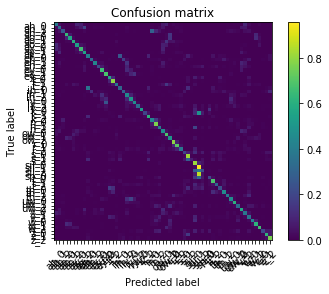

Model accuracy - frame by frame - phoneme level: 0.6895732051599481
Normalized confusion matrix
[[3.86735856e-01 3.02154493e-03 1.83000525e-01 8.16692941e-03
  6.26204239e-03 2.14573480e-03 9.45874934e-03 3.98493607e-03
  3.50324050e-04 1.21277807e-01 8.58293922e-02 2.83981433e-02
  1.75162025e-04 8.75810124e-05 0.00000000e+00 5.47381328e-04
  8.58293922e-03 2.54641794e-02 1.16614118e-01 9.43685409e-03
  4.59800315e-04]
 [1.90191550e-03 6.79436671e-01 6.61142055e-03 2.26418512e-04
  1.58492958e-04 1.07095956e-02 0.00000000e+00 9.05674048e-05
  0.00000000e+00 2.26418512e-04 1.74206403e-01 2.31852556e-02
  2.26418512e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 7.24539238e-04 4.98120726e-04 1.01978898e-01
  2.26418512e-05]
 [1.27675421e-01 5.27244218e-03 6.72981184e-01 9.21207370e-04
  1.08094865e-02 2.31281850e-03 2.18541748e-03 1.00940808e-03
  6.27205018e-04 4.09643277e-03 1.02822423e-01 1.90023520e-02
  8.82007056e-05 6.86005488e-05 0.00000000e+00 2.54802038e-04


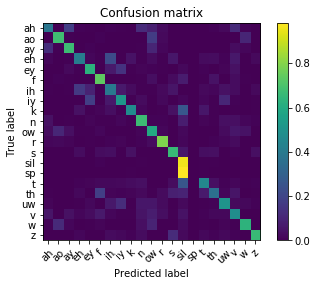

Edit distance - state level: 0.595052636729337
Edit distance - phoneme level: 0.7584058009703878


In [5]:
#lmfcc_ndy
DEFAULT_TEST_INPUTS_PATH = "final_data/lmfcc_ndy/X_test.npy"
DEFAULT_TEST_OUTPUTS_PATH = "final_data/lmfcc_ndy/y_test.npy"
DEFAULT_SAVED_MODEL_PATH =  'final_data/model_lmfcc_ndy.h5'
DEFAULT_STATE_LIST_PATH = "Lab3_files/state_list.npy"
DEFAULT_PHONEME_LIST_PATH = "Lab3_files/phoneme_list.npy"
DEFAULT_FEATURES = "lmfcc"
DEFAULT_DYNAMIC = False
# Load state list
state_list = list(np.load(DEFAULT_STATE_LIST_PATH))
labels = [i for i in range(len(state_list))] # List of labels to index the confusion matrix
output_dim = len(state_list)



# Load test dataset
X_test = np.load(DEFAULT_TEST_INPUTS_PATH)
y_test = np.load(DEFAULT_TEST_OUTPUTS_PATH)
y_test = np_utils.to_categorical(y_test, output_dim)

# Load neural network model trained in keras
model = load_model(DEFAULT_SAVED_MODEL_PATH)

# Run inference
predictions = model.predict(X_test)

# Use argmax to get the predicted class index
ground_truths = np.argmax(y_test, axis = 1)
predicted_classes = np.argmax(predictions, axis = 1)

############ Compute accuracy on a frame by frame basis at the state level ##############
accuracy = np.count_nonzero(ground_truths == predicted_classes) / float(len(ground_truths))
print("Model accuracy - frame by frame - state level: " + str(accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truths, predicted_classes, labels = labels)
plot_confusion_matrix(cnf_matrix, classes = state_list, normalize=True)
plt.show()


############## Compute accuracy on a frame by frame basis at the phoneme level ################
phoneme_dict = {phoneme: index for (index, phoneme) in enumerate(np.load(DEFAULT_PHONEME_LIST_PATH))}

# Convert state prediction to phonemes
phoneme_ground_truths = np.array([phoneme_dict[state_list[gt][:-2]] for gt in ground_truths])
phoneme_predicted_classes = np.array([phoneme_dict[state_list[pred][:-2]] for pred in predicted_classes])

phoneme_accuracy = np.count_nonzero(phoneme_ground_truths == phoneme_predicted_classes) / float(len(phoneme_ground_truths))
print("Model accuracy - frame by frame - phoneme level: " + str(phoneme_accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(phoneme_ground_truths, phoneme_predicted_classes, labels = list(phoneme_dict.values()))
plot_confusion_matrix(cnf_matrix, classes = list(phoneme_dict.keys()), normalize=True)
plt.show()



########## Compute accuracy on a frame by frame basis at the state level, merging adjacent identical states ###########
# Merge adjacent identical states
gt_transcription = [ground_truths[0]]
for i in range(1, len(ground_truths)):
    if ground_truths[i] != gt_transcription[-1]:
        gt_transcription.append(ground_truths[i])
predicted_transcription = [predicted_classes[0]]
for i in range(1, len(predicted_classes)):
    if predicted_classes[i] != predicted_transcription[-1]:
        predicted_transcription.append(predicted_classes[i])

gt_transcription = ''.join(str(x) for x in gt_transcription)
predicted_transcription = ''.join(str(x) for x in predicted_transcription)

edit_distance = distance(gt_transcription, predicted_transcription) / max(len(gt_transcription), len(predicted_transcription))
print("Edit distance - state level: " + str(edit_distance))

########## Compute accuracy on a frame by frame basis at the phoneme level, merging adjacent identical states ###########
# Merge adjacent identical states
gt_phon_transcription = [phoneme_ground_truths[0]]
for i in range(1, len(phoneme_ground_truths)):
    if phoneme_ground_truths[i] != gt_phon_transcription[-1]:
        gt_phon_transcription.append(phoneme_ground_truths[i])

predicted_phon_transcription = [phoneme_predicted_classes[0]]
for i in range(1, len(phoneme_predicted_classes)):
    if phoneme_predicted_classes[i] != predicted_phon_transcription[-1]:
        predicted_phon_transcription.append(phoneme_predicted_classes[i])

gt_phon_transcription = ''.join(str(x) for x in gt_phon_transcription)
predicted_phon_transcription = ''.join(str(x) for x in predicted_phon_transcription)

edit_distance_phon = distance(gt_phon_transcription, predicted_phon_transcription) / max(len(gt_phon_transcription), len(predicted_phon_transcription))
print("Edit distance - phoneme level: " + str(edit_distance_phon))

Model accuracy - frame by frame - state level: 0.7655294291804056
Normalized confusion matrix
[[6.91384893e-01 5.05865492e-02 6.52900897e-03 ... 2.65406869e-04
  0.00000000e+00 2.12325495e-04]
 [3.14368370e-02 6.98489232e-01 4.55159113e-02 ... 2.57152041e-04
  0.00000000e+00 6.42880103e-05]
 [5.85210144e-03 3.91026778e-02 5.59585033e-01 ... 1.06401844e-03
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 1.45137881e-03 ... 6.44573456e-01
  6.11191743e-02 1.41912595e-02]
 [7.33460466e-05 0.00000000e+00 0.00000000e+00 ... 4.93618894e-02
  7.67639724e-01 4.96552736e-02]
 [8.92379083e-05 0.00000000e+00 0.00000000e+00 ... 9.01302873e-03
  3.66767803e-02 8.88184901e-01]]


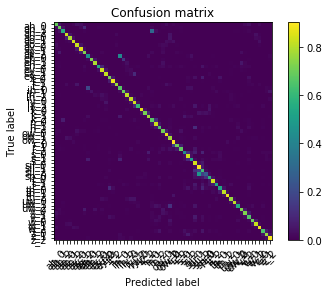

Model accuracy - frame by frame - phoneme level: 0.8512231099862316
Normalized confusion matrix
[[7.22127343e-01 4.68558417e-03 7.87134349e-02 5.47381328e-04
  5.93361359e-03 5.69276581e-04 1.40129620e-03 8.75810124e-04
  2.18952531e-05 9.32956735e-02 2.54203889e-02 1.43851813e-02
  4.37905062e-05 4.37905062e-05 0.00000000e+00 1.97057278e-04
  7.88229112e-04 5.05780347e-03 3.66088632e-02 8.71431074e-03
  5.69276581e-04]
 [1.26794367e-03 8.85386949e-01 2.19625957e-03 9.05674048e-05
  1.13209256e-04 8.15106643e-03 2.26418512e-05 0.00000000e+00
  2.26418512e-05 1.13209256e-04 4.96535797e-02 1.24983019e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.16985917e-04 2.71702214e-04 3.98949418e-02
  0.00000000e+00]
 [3.48686789e-02 1.78361427e-03 8.90003920e-01 2.84202274e-04
  3.63582909e-03 4.42963544e-03 8.82007056e-05 2.05801646e-04
  0.00000000e+00 1.03194826e-02 2.87926303e-02 8.92787142e-03
  5.88004704e-05 1.96001568e-05 0.00000000e+00 7.84006272e-05


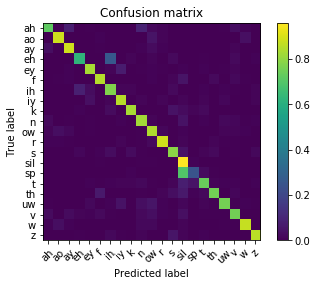

Edit distance - state level: 0.3828898174620629
Edit distance - phoneme level: 0.5521048228034301


In [11]:
#lmfcc_dy
DEFAULT_TEST_INPUTS_PATH = "final_data/lmfcc_dy/X_test.npy"
DEFAULT_TEST_OUTPUTS_PATH = "final_data/lmfcc_dy/y_test.npy"
DEFAULT_SAVED_MODEL_PATH =  'final_data/model_lmfcc_dy.h5'
DEFAULT_STATE_LIST_PATH = "Lab3_files/state_list.npy"
DEFAULT_PHONEME_LIST_PATH = "Lab3_files/phoneme_list.npy"
DEFAULT_FEATURES = "lmfcc"
DEFAULT_DYNAMIC = False
# Load state list
state_list = list(np.load(DEFAULT_STATE_LIST_PATH))
labels = [i for i in range(len(state_list))] # List of labels to index the confusion matrix
output_dim = len(state_list)



# Load test dataset
X_test = np.load(DEFAULT_TEST_INPUTS_PATH)
y_test = np.load(DEFAULT_TEST_OUTPUTS_PATH)
y_test = np_utils.to_categorical(y_test, output_dim)

# Load neural network model trained in keras
model = load_model(DEFAULT_SAVED_MODEL_PATH)

# Run inference
predictions = model.predict(X_test)

# Use argmax to get the predicted class index
ground_truths = np.argmax(y_test, axis = 1)
predicted_classes = np.argmax(predictions, axis = 1)

############ Compute accuracy on a frame by frame basis at the state level ##############
accuracy = np.count_nonzero(ground_truths == predicted_classes) / float(len(ground_truths))
print("Model accuracy - frame by frame - state level: " + str(accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truths, predicted_classes, labels = labels)
plot_confusion_matrix(cnf_matrix, classes = state_list, normalize=True)
plt.show()


############## Compute accuracy on a frame by frame basis at the phoneme level ################
phoneme_dict = {phoneme: index for (index, phoneme) in enumerate(np.load(DEFAULT_PHONEME_LIST_PATH))}

# Convert state prediction to phonemes
phoneme_ground_truths = np.array([phoneme_dict[state_list[gt][:-2]] for gt in ground_truths])
phoneme_predicted_classes = np.array([phoneme_dict[state_list[pred][:-2]] for pred in predicted_classes])

phoneme_accuracy = np.count_nonzero(phoneme_ground_truths == phoneme_predicted_classes) / float(len(phoneme_ground_truths))
print("Model accuracy - frame by frame - phoneme level: " + str(phoneme_accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(phoneme_ground_truths, phoneme_predicted_classes, labels = list(phoneme_dict.values()))
plot_confusion_matrix(cnf_matrix, classes = list(phoneme_dict.keys()), normalize=True)
plt.show()



########## Compute accuracy on a frame by frame basis at the state level, merging adjacent identical states ###########
# Merge adjacent identical states
gt_transcription = [ground_truths[0]]
for i in range(1, len(ground_truths)):
    if ground_truths[i] != gt_transcription[-1]:
        gt_transcription.append(ground_truths[i])
predicted_transcription = [predicted_classes[0]]
for i in range(1, len(predicted_classes)):
    if predicted_classes[i] != predicted_transcription[-1]:
        predicted_transcription.append(predicted_classes[i])

gt_transcription = ''.join(str(x) for x in gt_transcription)
predicted_transcription = ''.join(str(x) for x in predicted_transcription)

edit_distance = distance(gt_transcription, predicted_transcription) / max(len(gt_transcription), len(predicted_transcription))
print("Edit distance - state level: " + str(edit_distance))

########## Compute accuracy on a frame by frame basis at the phoneme level, merging adjacent identical states ###########
# Merge adjacent identical states
gt_phon_transcription = [phoneme_ground_truths[0]]
for i in range(1, len(phoneme_ground_truths)):
    if phoneme_ground_truths[i] != gt_phon_transcription[-1]:
        gt_phon_transcription.append(phoneme_ground_truths[i])

predicted_phon_transcription = [phoneme_predicted_classes[0]]
for i in range(1, len(phoneme_predicted_classes)):
    if phoneme_predicted_classes[i] != predicted_phon_transcription[-1]:
        predicted_phon_transcription.append(phoneme_predicted_classes[i])

gt_phon_transcription = ''.join(str(x) for x in gt_phon_transcription)
predicted_phon_transcription = ''.join(str(x) for x in predicted_phon_transcription)

edit_distance_phon = distance(gt_phon_transcription, predicted_phon_transcription) / max(len(gt_phon_transcription), len(predicted_phon_transcription))
print("Edit distance - phoneme level: " + str(edit_distance_phon))

Model accuracy - frame by frame - state level: 0.609676409363574
Normalized confusion matrix
[[4.86756197e-01 2.99378948e-02 6.58209034e-03 ... 2.65406869e-04
  0.00000000e+00 5.30813737e-05]
 [5.52234008e-02 3.89135326e-01 3.07939569e-02 ... 1.92864031e-04
  0.00000000e+00 3.85728062e-04]
 [1.49849264e-02 2.93491754e-02 3.28427026e-01 ... 1.77336407e-03
  8.86682036e-05 3.54672814e-04]
 ...
 [1.61264312e-04 8.06321561e-04 1.93517175e-03 ... 2.74471859e-01
  4.35413643e-02 6.53120464e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.83115740e-02
  5.55816341e-01 6.54980197e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.43619490e-02
  1.89184366e-02 7.45493486e-01]]


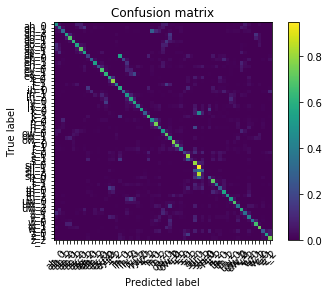

Model accuracy - frame by frame - phoneme level: 0.7118240733826691
Normalized confusion matrix
[[4.69718865e-01 1.83920126e-03 1.41093011e-01 8.34209143e-03
  7.86039587e-03 1.68593449e-03 7.11595726e-03 5.49570853e-03
  1.09476266e-04 1.26642144e-01 8.91793659e-02 2.17857768e-02
  1.31371519e-04 1.09476266e-04 0.00000000e+00 7.44438606e-04
  7.77281485e-03 1.64871256e-02 8.26107900e-02 1.04002452e-02
  8.75810124e-04]
 [9.96241453e-04 6.98659602e-01 2.46796178e-03 4.52837024e-05
  3.16985917e-04 7.96993162e-03 4.52837024e-05 4.52837024e-05
  0.00000000e+00 1.58492958e-04 1.67074220e-01 2.02644568e-02
  6.79255536e-05 2.26418512e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.16985917e-04 2.71702214e-04 1.01277000e-01
  0.00000000e+00]
 [1.36270090e-01 1.83261466e-03 6.91121129e-01 7.93806350e-04
  1.29949040e-02 2.56762054e-03 1.96981576e-03 7.05605645e-04
  1.66601333e-04 6.05644845e-03 8.97687181e-02 1.01136809e-02
  2.94002352e-05 3.92003136e-05 0.00000000e+00 3.23402587e-04


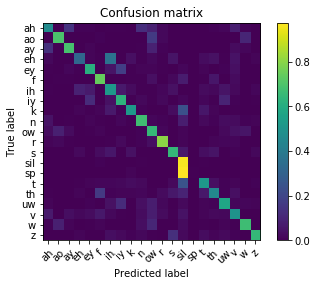

Edit distance - state level: 0.5830782005815567
Edit distance - phoneme level: 0.7437950021177467


In [14]:
#mspec_ndy
DEFAULT_TEST_INPUTS_PATH = "final_data/mspec_ndy/X_test.npy"
DEFAULT_TEST_OUTPUTS_PATH = "final_data/mspec_ndy/y_test.npy"
DEFAULT_SAVED_MODEL_PATH =  'final_data/model_mspec_ndy.h5'
DEFAULT_STATE_LIST_PATH = "Lab3_files/state_list.npy"
DEFAULT_PHONEME_LIST_PATH = "Lab3_files/phoneme_list.npy"
DEFAULT_FEATURES = "lmfcc"
DEFAULT_DYNAMIC = False
# Load state list
state_list = list(np.load(DEFAULT_STATE_LIST_PATH))
labels = [i for i in range(len(state_list))] # List of labels to index the confusion matrix
output_dim = len(state_list)



# Load test dataset
X_test = np.load(DEFAULT_TEST_INPUTS_PATH)
y_test = np.load(DEFAULT_TEST_OUTPUTS_PATH)
y_test = np_utils.to_categorical(y_test, output_dim)

# Load neural network model trained in keras
model = load_model(DEFAULT_SAVED_MODEL_PATH)

# Run inference
predictions = model.predict(X_test)

# Use argmax to get the predicted class index
ground_truths = np.argmax(y_test, axis = 1)
predicted_classes = np.argmax(predictions, axis = 1)

############ Compute accuracy on a frame by frame basis at the state level ##############
accuracy = np.count_nonzero(ground_truths == predicted_classes) / float(len(ground_truths))
print("Model accuracy - frame by frame - state level: " + str(accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truths, predicted_classes, labels = labels)
plot_confusion_matrix(cnf_matrix, classes = state_list, normalize=True)
plt.show()


############## Compute accuracy on a frame by frame basis at the phoneme level ################
phoneme_dict = {phoneme: index for (index, phoneme) in enumerate(np.load(DEFAULT_PHONEME_LIST_PATH))}

# Convert state prediction to phonemes
phoneme_ground_truths = np.array([phoneme_dict[state_list[gt][:-2]] for gt in ground_truths])
phoneme_predicted_classes = np.array([phoneme_dict[state_list[pred][:-2]] for pred in predicted_classes])

phoneme_accuracy = np.count_nonzero(phoneme_ground_truths == phoneme_predicted_classes) / float(len(phoneme_ground_truths))
print("Model accuracy - frame by frame - phoneme level: " + str(phoneme_accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(phoneme_ground_truths, phoneme_predicted_classes, labels = list(phoneme_dict.values()))
plot_confusion_matrix(cnf_matrix, classes = list(phoneme_dict.keys()), normalize=True)
plt.show()



########## Compute accuracy on a frame by frame basis at the state level, merging adjacent identical states ###########
# Merge adjacent identical states
gt_transcription = [ground_truths[0]]
for i in range(1, len(ground_truths)):
    if ground_truths[i] != gt_transcription[-1]:
        gt_transcription.append(ground_truths[i])
predicted_transcription = [predicted_classes[0]]
for i in range(1, len(predicted_classes)):
    if predicted_classes[i] != predicted_transcription[-1]:
        predicted_transcription.append(predicted_classes[i])

gt_transcription = ''.join(str(x) for x in gt_transcription)
predicted_transcription = ''.join(str(x) for x in predicted_transcription)

edit_distance = distance(gt_transcription, predicted_transcription) / max(len(gt_transcription), len(predicted_transcription))
print("Edit distance - state level: " + str(edit_distance))

########## Compute accuracy on a frame by frame basis at the phoneme level, merging adjacent identical states ###########
# Merge adjacent identical states
gt_phon_transcription = [phoneme_ground_truths[0]]
for i in range(1, len(phoneme_ground_truths)):
    if phoneme_ground_truths[i] != gt_phon_transcription[-1]:
        gt_phon_transcription.append(phoneme_ground_truths[i])

predicted_phon_transcription = [phoneme_predicted_classes[0]]
for i in range(1, len(phoneme_predicted_classes)):
    if phoneme_predicted_classes[i] != predicted_phon_transcription[-1]:
        predicted_phon_transcription.append(phoneme_predicted_classes[i])

gt_phon_transcription = ''.join(str(x) for x in gt_phon_transcription)
predicted_phon_transcription = ''.join(str(x) for x in predicted_phon_transcription)

edit_distance_phon = distance(gt_phon_transcription, predicted_phon_transcription) / max(len(gt_phon_transcription), len(predicted_phon_transcription))
print("Edit distance - phoneme level: " + str(edit_distance_phon))

Model accuracy - frame by frame - state level: 0.7665840037414471
Normalized confusion matrix
[[6.34693986e-01 6.12559053e-02 3.55645204e-03 ... 1.06162747e-04
  0.00000000e+00 0.00000000e+00]
 [2.57152041e-02 7.19254259e-01 3.07296689e-02 ... 4.50016072e-04
  6.42880103e-05 0.00000000e+00]
 [5.85210144e-03 5.69249867e-02 6.06224508e-01 ... 8.86682036e-04
  0.00000000e+00 8.86682036e-05]
 ...
 [0.00000000e+00 0.00000000e+00 8.06321561e-04 ... 5.62167392e-01
  9.20819223e-02 9.35333011e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.17339005e-02
  8.11940736e-01 3.05119554e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.47760129e-03
  6.61252900e-02 8.46778512e-01]]


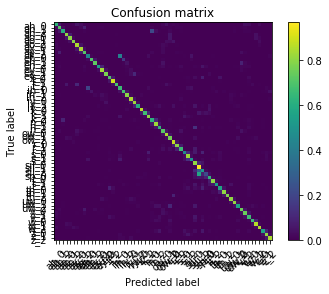

Model accuracy - frame by frame - phoneme level: 0.8533899004507814
Normalized confusion matrix
[[7.17923454e-01 3.72219303e-03 7.58451568e-02 1.75162025e-04
  7.33490979e-03 3.50324050e-04 2.34279208e-03 1.29181993e-03
  0.00000000e+00 6.91671046e-02 4.25205815e-02 1.88956034e-02
  6.56857593e-05 4.37905062e-05 0.00000000e+00 3.50324050e-04
  5.03590822e-04 6.13067087e-03 4.19294097e-02 1.09476266e-02
  4.59800315e-04]
 [1.60757144e-03 8.73726396e-01 1.83398995e-03 4.52837024e-05
  2.03776661e-04 2.58117104e-03 2.26418512e-05 2.26418512e-05
  2.26418512e-05 1.13209256e-04 5.73970928e-02 1.63247747e-02
  2.26418512e-05 2.26418512e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.03776661e-04 6.79255536e-05 4.57818231e-02
  0.00000000e+00]
 [3.70050960e-02 1.26421011e-03 8.93100745e-01 2.94002352e-05
  3.74362995e-03 2.00901607e-03 9.80007840e-05 3.72402979e-04
  0.00000000e+00 7.21285770e-03 2.77538220e-02 7.83026264e-03
  9.80007840e-06 6.86005488e-05 0.00000000e+00 7.84006272e-05


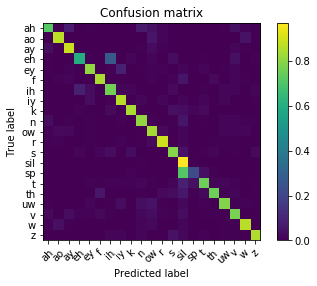

Edit distance - state level: 0.35642646334446804
Edit distance - phoneme level: 0.5267937076352475


In [15]:
#mspec_dy
DEFAULT_TEST_INPUTS_PATH = "final_data/mspec_dy/X_test.npy"
DEFAULT_TEST_OUTPUTS_PATH = "final_data/mspec_dy/y_test.npy"
DEFAULT_SAVED_MODEL_PATH =  'final_data/model_mspec_dy.h5'
DEFAULT_STATE_LIST_PATH = "Lab3_files/state_list.npy"
DEFAULT_PHONEME_LIST_PATH = "Lab3_files/phoneme_list.npy"
DEFAULT_FEATURES = "lmfcc"
DEFAULT_DYNAMIC = False
# Load state list
state_list = list(np.load(DEFAULT_STATE_LIST_PATH))
labels = [i for i in range(len(state_list))] # List of labels to index the confusion matrix
output_dim = len(state_list)



# Load test dataset
X_test = np.load(DEFAULT_TEST_INPUTS_PATH)
y_test = np.load(DEFAULT_TEST_OUTPUTS_PATH)
y_test = np_utils.to_categorical(y_test, output_dim)

# Load neural network model trained in keras
model = load_model(DEFAULT_SAVED_MODEL_PATH)

# Run inference
predictions = model.predict(X_test)

# Use argmax to get the predicted class index
ground_truths = np.argmax(y_test, axis = 1)
predicted_classes = np.argmax(predictions, axis = 1)

############ Compute accuracy on a frame by frame basis at the state level ##############
accuracy = np.count_nonzero(ground_truths == predicted_classes) / float(len(ground_truths))
print("Model accuracy - frame by frame - state level: " + str(accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truths, predicted_classes, labels = labels)
plot_confusion_matrix(cnf_matrix, classes = state_list, normalize=True)
plt.show()


############## Compute accuracy on a frame by frame basis at the phoneme level ################
phoneme_dict = {phoneme: index for (index, phoneme) in enumerate(np.load(DEFAULT_PHONEME_LIST_PATH))}

# Convert state prediction to phonemes
phoneme_ground_truths = np.array([phoneme_dict[state_list[gt][:-2]] for gt in ground_truths])
phoneme_predicted_classes = np.array([phoneme_dict[state_list[pred][:-2]] for pred in predicted_classes])

phoneme_accuracy = np.count_nonzero(phoneme_ground_truths == phoneme_predicted_classes) / float(len(phoneme_ground_truths))
print("Model accuracy - frame by frame - phoneme level: " + str(phoneme_accuracy))

# Compute confusion matrix
cnf_matrix = confusion_matrix(phoneme_ground_truths, phoneme_predicted_classes, labels = list(phoneme_dict.values()))
plot_confusion_matrix(cnf_matrix, classes = list(phoneme_dict.keys()), normalize=True)
plt.show()



########## Compute accuracy on a frame by frame basis at the state level, merging adjacent identical states ###########
# Merge adjacent identical states
gt_transcription = [ground_truths[0]]
for i in range(1, len(ground_truths)):
    if ground_truths[i] != gt_transcription[-1]:
        gt_transcription.append(ground_truths[i])
predicted_transcription = [predicted_classes[0]]
for i in range(1, len(predicted_classes)):
    if predicted_classes[i] != predicted_transcription[-1]:
        predicted_transcription.append(predicted_classes[i])

gt_transcription = ''.join(str(x) for x in gt_transcription)
predicted_transcription = ''.join(str(x) for x in predicted_transcription)

edit_distance = distance(gt_transcription, predicted_transcription) / max(len(gt_transcription), len(predicted_transcription))
print("Edit distance - state level: " + str(edit_distance))

########## Compute accuracy on a frame by frame basis at the phoneme level, merging adjacent identical states ###########
# Merge adjacent identical states
gt_phon_transcription = [phoneme_ground_truths[0]]
for i in range(1, len(phoneme_ground_truths)):
    if phoneme_ground_truths[i] != gt_phon_transcription[-1]:
        gt_phon_transcription.append(phoneme_ground_truths[i])

predicted_phon_transcription = [phoneme_predicted_classes[0]]
for i in range(1, len(phoneme_predicted_classes)):
    if phoneme_predicted_classes[i] != predicted_phon_transcription[-1]:
        predicted_phon_transcription.append(phoneme_predicted_classes[i])

gt_phon_transcription = ''.join(str(x) for x in gt_phon_transcription)
predicted_phon_transcription = ''.join(str(x) for x in predicted_phon_transcription)

edit_distance_phon = distance(gt_phon_transcription, predicted_phon_transcription) / max(len(gt_phon_transcription), len(predicted_phon_transcription))
print("Edit distance - phoneme level: " + str(edit_distance_phon))